# Feature Engineering

1. Select low/high-variance variables
2. Dropping redundant variables
3. RFE

In [4]:
import pandas as pd
import dslabs_functions as dslabs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import subplots, show
from matplotlib.pyplot import savefig, figure

## tratar da primeira coluna nos notebooks anteriores
winning_alternative_scaling = 2
folder = "feat_eng_csvs"
filename = f'../data_preparation_csvs/scaling_csvs/data_scaling_alt1_zscore.csv'
data_scaling: pd.DataFrame = pd.read_csv(filename, sep=',', decimal='.', na_values='')
print(f"Dataset nr records={data_scaling.shape[0]}", f"nr variables={data_scaling.shape[1]}")
filename_prefix = "../data_preparation_csvs/feat_eng_csvs/data_feat_select_"

train = pd.read_csv('../data_preparation_csvs/scaling_csvs/train_data_scaling_alt1_zscore.csv')
test = pd.read_csv('../data_preparation_csvs/scaling_csvs/test_data_scaling_alt1_zscore.csv')

Dataset nr records=100000 nr variables=32


In [11]:
# Save to file
def save(df, name, file_tag):
    df.to_csv(f'{filename_prefix}{name}.csv', index=False)

    ## Separate into Train and Test and save in different files
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

    ## Save the training and testing sets to CSV files
    train_data.to_csv(f'../data_preparation_csvs/{folder}/train_data_feat_select_{name}.csv', index=False)
    test_data.to_csv(f'../data_preparation_csvs/{folder}/test_data_feat_select_{name}.csv', index=False)

    ## Evaluate Approach
    target = "Credit_Score"

    figure()
    eval: dict[str, list] = dslabs.evaluate_approach(train_data, test_data, target=target, metric="recall")
    dslabs.plot_multibar_chart(
        ["NB", "KNN"], eval, title=f"{file_tag}", percentage=True
    )
    savefig(f"../data_preparation_images/feat_eng_result/data_mv_{name}.png")
    show()

## 1.1 Alternativa - Low variance

Original variables ['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'CreditMix', 'OutstandingDebt', 'CreditUtilizationRatio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'Payment_Behaviour', 'MonthlyBalance', 'Payday Loan', 'Auto Loan', 'Home Equity Loan', 'Student Loan', 'Credit-Builder Loan', 'Not Specified Loan', 'Mortgage Loan', 'Debt Consolidation Loan', 'Personal Loan', 'Credit_Score']
Variables to drop []


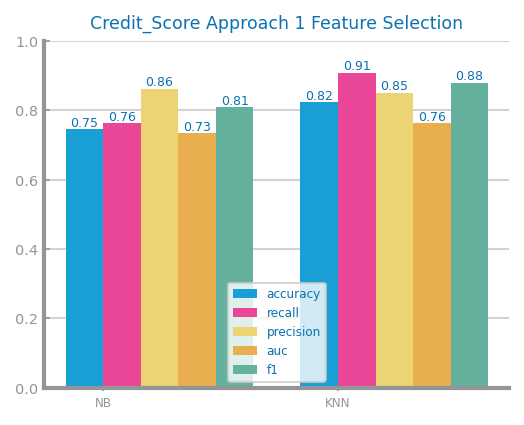

In [14]:
target = "Credit_Score"      # This method doesn't work when using zscore scaling for obvious reasons
file_tag = "Credit_Score Approach 1 Feature Selection"
threshold = 0.015


print("Original variables", data_scaling.columns.to_list())
vars2drop: list[str] = dslabs.select_low_variance_variables(data_scaling, threshold, target=target)
print("Variables to drop", vars2drop)

dropped = data_scaling.copy()
dropped.drop(columns=vars2drop)

save(dropped, "alt1_low_var", file_tag)

### Avaliacao threshold de variancia

  File "c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


{'NB': [0.7623531077445844, 0.7623531077445844, 0.7623531077445844], 'KNN': [0.908679031572986, 0.908679031572986, 0.908679031572986]}


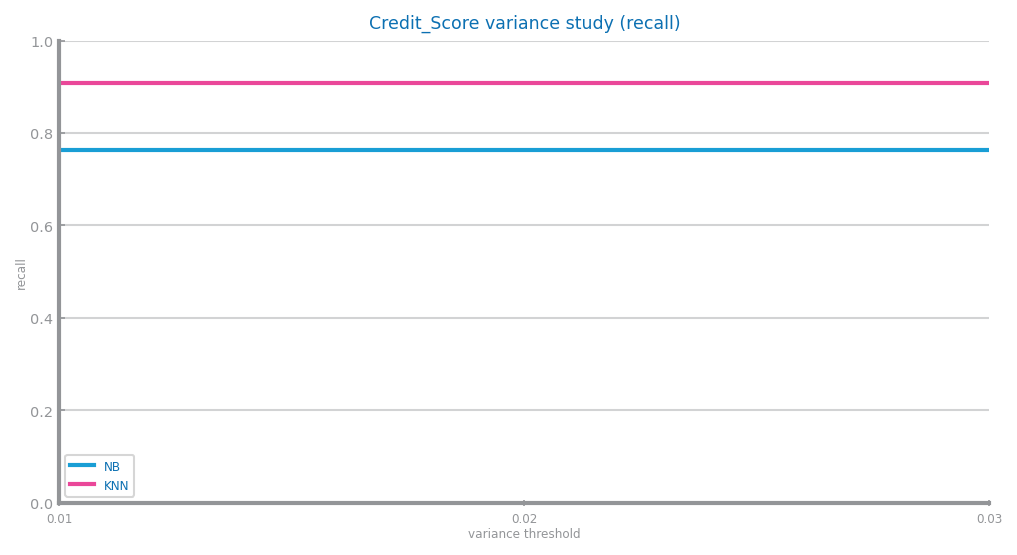

In [6]:
# Test variation thresholds

target = "Credit_Score"
file_tag = "Credit_Score"

eval_metric = "recall"
figure(figsize=(2 * dslabs.HEIGHT, dslabs.HEIGHT))
print(dslabs.study_variance_for_feature_selection(
   train,
   test,
   target=target,
   max_threshold=0.03,
   lag=0.01,
   metric=eval_metric,
   file_tag=file_tag,
))
show()

## 2. Alternativa - correlacao

Original variables ['Month' 'Age' 'Occupation' 'Annual_Income' 'Monthly_Inhand_Salary'
 'Num_Bank_Accounts' 'Num_Credit_Card' 'Interest_Rate' 'NumofLoan'
 'Delay_from_due_date' 'NumofDelayedPayment' 'ChangedCreditLimit'
 'NumCreditInquiries' 'CreditMix' 'OutstandingDebt'
 'CreditUtilizationRatio' 'Credit_History_Age' 'Payment_of_Min_Amount'
 'TotalEMIpermonth' 'Amountinvestedmonthly' 'Payment_Behaviour'
 'MonthlyBalance' 'Payday Loan' 'Auto Loan' 'Home Equity Loan'
 'Student Loan' 'Credit-Builder Loan' 'Not Specified Loan' 'Mortgage Loan'
 'Debt Consolidation Loan' 'Personal Loan' 'Credit_Score']
Variables to drop []


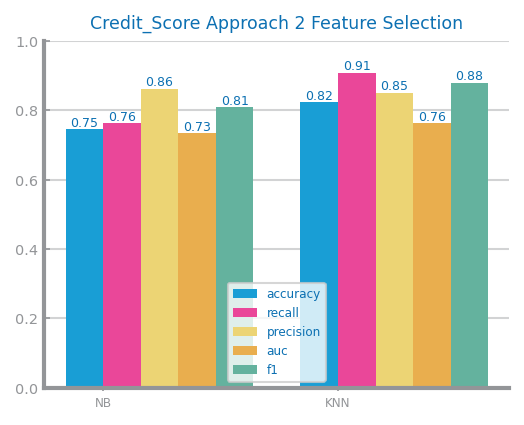

In [13]:
corr_threshold = 0.65
file_tag = "Credit_Score Approach 2 Feature Selection"

print("Original variables", train.columns.values)
vars2drop: list[str] = dslabs.select_redundant_variables(
    data_scaling, target=target, min_threshold=corr_threshold
)
print("Variables to drop", vars2drop)

dropped = data_scaling.copy()
dropped.drop(columns=vars2drop)

save(dropped, "alt2_correlation", file_tag)

## Estudo correlacao otimo

{'NB': [0.9970975506158856, 0.9951861815092736, 0.8053943083675492, 0.7958374628344896, 0.7952711312473453, 0.7963330029732408, 0.7864222001982161, 0.7901033555146538, 0.7623531077445844, 0.7623531077445844, 0.7623531077445844, 0.7623531077445844, 0.7623531077445844, 0.7623531077445844, 0.7623531077445844, 0.7623531077445844], 'KNN': [0.8908395865779414, 0.8845391476709613, 0.9313322950587569, 0.9278635140874982, 0.9347302845816226, 0.9185190428996177, 0.9162537165510406, 0.9130681013733541, 0.908679031572986, 0.908679031572986, 0.908679031572986, 0.908679031572986, 0.908679031572986, 0.908679031572986, 0.908679031572986, 0.908679031572986]}


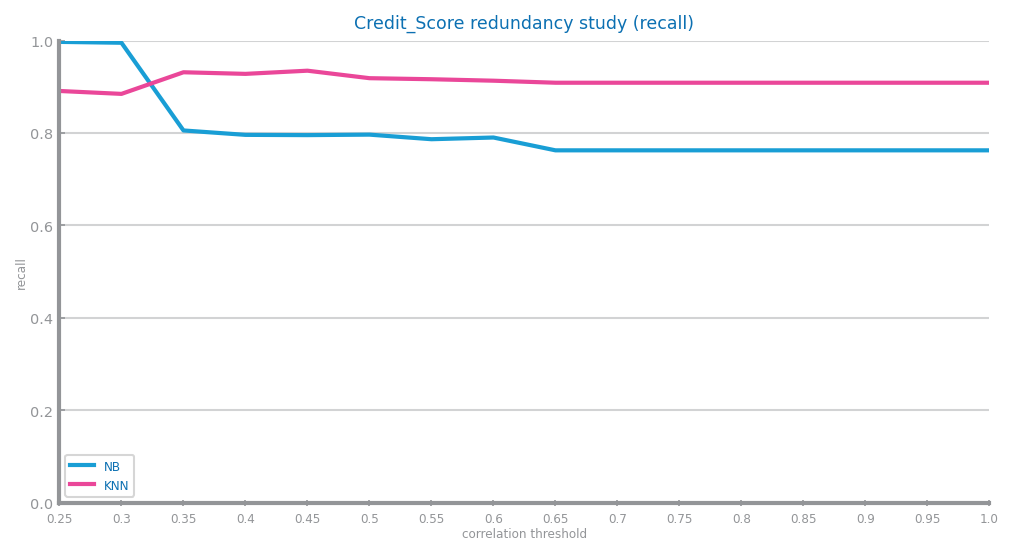

In [8]:
# Determinacao de valor otimo de corr threshold

eval_metric = "recall"
file_tag = "Credit_Score"

figure(figsize=(2 * dslabs.HEIGHT, dslabs.HEIGHT))
print(dslabs.study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
))
show()

{'NB': [0.8400763639033703, 0.8444428184678422, 0.8588253172251349, 0.8617200674536256, 0.8622304090874203, 0.8720831072176137, 0.8740864315220845, 0.8748705694942254, 0.8788002615233736, 0.8788002615233736, 0.8788002615233736, 0.8788002615233736, 0.8788002615233736, 0.8788002615233736, 0.8788002615233736, 0.8788002615233736], 'KNN': [0.8207681365576103, 0.8250153615074759, 0.8564616787041582, 0.8580967107112736, 0.8611287254280279, 0.8727362412796843, 0.8756863297198367, 0.8817855382665634, 0.8865644215138879, 0.8865644215138879, 0.8865644215138879, 0.8865644215138879, 0.8865644215138879, 0.8865644215138879, 0.8865644215138879, 0.8865644215138879]}


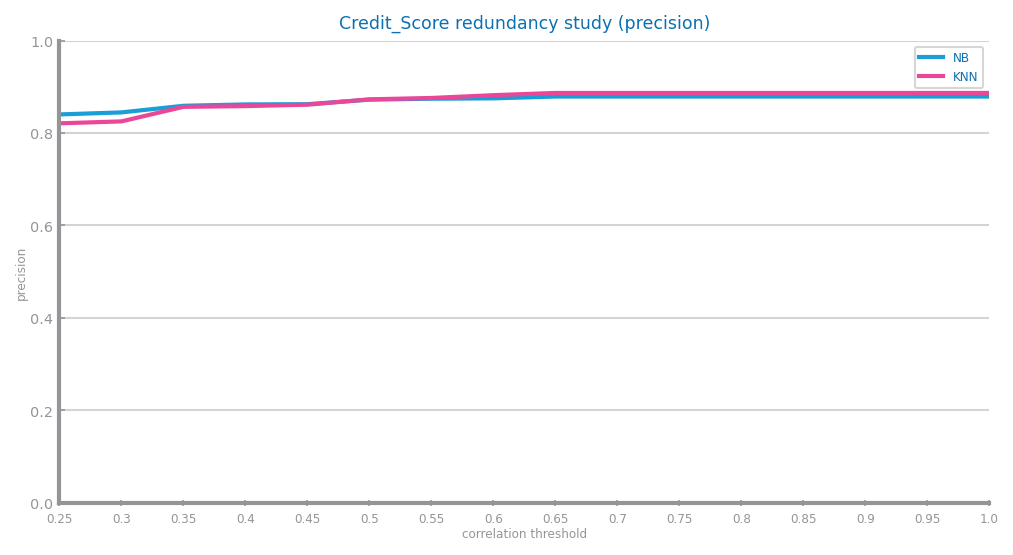

In [9]:

eval_metric = "precision"
target="Credit_Score"
file_tag = "Credit_Score"

figure(figsize=(2 * dslabs.HEIGHT, dslabs.HEIGHT))
print(dslabs.study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
))
show()

## 3. Alternativa - RFE
*Este ultimo tem que se explicar bem pq nao faz parte do que ela da*

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
99995    0.0
99996    0.0
99997    0.0
99998    1.0
99999    0.0
Name: Credit_Score, Length: 100000, dtype: float64
Selected Features for LogisticRegression:
Index(['Month', 'Age', 'Occupation', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
       'Delay_from_due_date', 'ChangedCreditLimit', 'NumCreditInquiries',
       'CreditMix', 'OutstandingDebt', 'CreditUtilizationRatio',
       'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour',
       'Payday Loan', 'Auto Loan', 'Home Equity Loan', 'Student Loan',
       'Credit-Builder Loan', 'Not Specified Loan', 'Mortgage Loan',
       'Debt Consolidation Loan', 'Personal Loan', 'Credit_Score'],
      dtype='object')




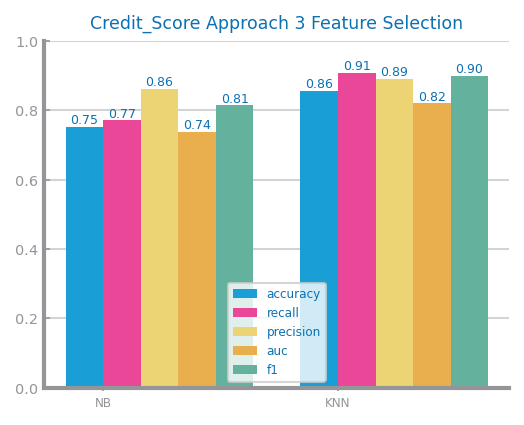

In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import pandas as pd

# Assuming your data is loaded into a pandas DataFrame 'data'
# 'target_column' refers to the column you want to predict/classify

# Replace these with your actual data and target column
target = 'Credit_Score'  # Your target column name
file_tag = "Credit_Score Approach 3 Feature Selection"

X = data_scaling.copy()
print(X["Credit_Score"])
X.drop(columns=["Credit_Score"])

y = data_scaling[target]

# List of models to test
models = [
    LogisticRegression()                                       # GANHA ESTE
   # RandomForestClassifier(),
    #GradientBoostingClassifier()
]

# Iterate through each model and perform RFE
for model in models:
    model_name = model.__class__.__name__
    rfe = RFE(model, n_features_to_select=26)  # Adjust the number of features as needed
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    vars2drop = X.columns[~rfe.support_]
    print(f"Selected Features for {model_name}:")
    print(selected_features)
    print("\n")
    save(data_scaling[selected_features], "alt3_RFE", file_tag)

# Resumindo

1. Como o zscaler ganhou no scaling (e é o único que faz sentido no nosso caso), a alternativa da variância é descartada.
2. A alternativa da correlação mostra os melhores valores até um t de 0.54. Como a ideia é não perder informação, optamos por este porque apenas descarta duas variáveis (outros valores para o threshold mostram métricas iguais, sem melhoria)
3. Quanto ao RFE, mostrou melhores resultados quando usado com modelo de regressão logística. Testei com n/2 e 25 features, e 25 mostrou os melhores resultados de todos.